In [1]:
""" Experiment Settings """
depth_tree, depth_query = 5, 5
threshold_size = 100
scale = 1
times = 10
flag = True
res = []

In [2]:
""" Libraries """
import json
import numpy as np
import pandas as pd
import psycopg2
from matplotlib import pyplot as plt

import nbimporter
from Core import Ranges, nDTree, tree_shape_relation, draw_lines, draw_box, experiment_execution

In [ ]:
""" Database Connection """
conn_params = "dbname='trajectory' user='gpadmin' host='192.168.59.101' password='1234' port=5432"
conn = psycopg2.connect(conn_params)
cur = conn.cursor()

In [109]:
""" Experiment Preparation: create taxi table """
sql_taxi_table = """
DROP TABLE IF EXISTS taxi_table;
CREATE TABLE taxi_table
(
    taxiid BIGINT
);

INSERT INTO taxi_table (taxiid)
SELECT DISTINCT taxiid
FROM traj
WHERE taxiid IS NOT NULL
LIMIT 100 * {};
""".format(scale)

cur.execute(sql_taxi_table)
conn.commit()

In [110]:
""" Experiment 5-a """
sql_experiment_5_a = """
SELECT st_astext(traj.geometry) AS geometry, traj.state
FROM traj,
     taxi_table
WHERE traj.taxiid = taxi_table.taxiid;
"""

timings = []
print("experiment 5-a")
records = experiment_execution(times, timings, sql_experiment_5_a, cur, flag)
print("timings:", timings)
print("median:", np.median(timings))
res.append(np.median(timings))

experiment 5-a


100%|██████████| 1/1 [00:16<00:00, 16.64s/it]

timings: [16.6404128074646]
median: 16.6404128074646


In [111]:
""" Visualization 5-a """
columns = [desc[0] for desc in cur.description]
df = pd.DataFrame(records, columns=columns)
#draw_lines(df, "t5-a-{}".format(scale))

In [112]:
""" Experiment 5-b """
sql_experiment_5_b = """
SELECT st_astext(traj.geometry) AS geometry, traj.state
FROM traj,
     taxi_table
WHERE traj.taxiid = taxi_table.taxiid
  AND traj.state = 1;
"""

timings = []
print("experiment 5-b")
records = experiment_execution(times, timings, sql_experiment_5_b, cur, flag)
print("timings:", timings)
print("median:", np.median(timings))
res.append(np.median(timings))

experiment 5-b


100%|██████████| 1/1 [00:04<00:00,  4.91s/it]

timings: [4.9075634479522705]
median: 4.9075634479522705


In [113]:
""" Visualization 5-b """
columns = [desc[0] for desc in cur.description]
df = pd.DataFrame(records, columns=columns)
#draw_lines(df, "t5-b-{}".format(scale))

{'min': [0.1, 0.1, 0.1], 'max': [0.5762203155904598, 0.5762203155904598, 0.5762203155904598]}


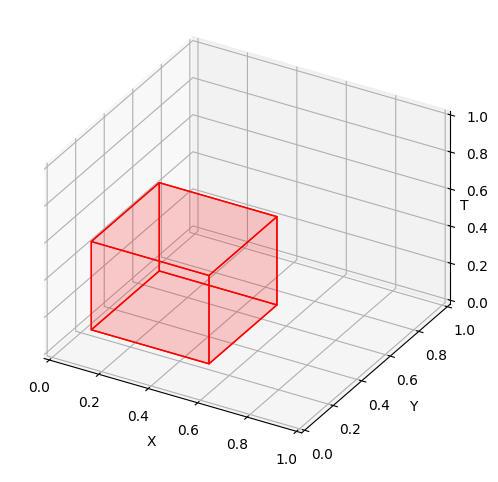

In [114]:
""" Experiment Preparation: read parameters """
with open("para.json", "r") as json_file:
    para = json.load(json_file)
fold_para = para["fold_para"]
with open("{}/para_{}.json".format(fold_para, depth_tree), "r") as json_file:
    para = json.load(json_file)

dist = para["dist"]
x_scl = para["x_scl"]
y_scl = para["y_scl"]
t_scl = para["t_scl"]
""" Experiment Preparation: set query shape """
factor = pow(scale, 1 / 3)
queryShape = {"min": [0.1, 0.1, 0.1], "max": [0.1 + 0.3 * factor, 0.1 + 0.3 * factor, 0.1 + 0.3 * factor]}
print(queryShape)
draw_box(queryShape, "t5-c-box-{}".format(scale))

In [115]:
""" Experiment Preparation: calculate ranges """
index_scale = 2 ** depth_tree
queryShape["min"] = [coord * index_scale for coord in queryShape["min"]]
queryShape["max"] = [coord * index_scale for coord in queryShape["max"]]
print(queryShape)

# initialize tree
tree = nDTree(depth_tree, dist, threshold_size)
# calculate ranges
values = tree.shapeQuery(queryShape, depth_query, tree_shape_relation)
# initialize ranges (do clean merge)
ranges_merged = Ranges(values)
# only the relevant ranges
ranges = [(range[0], range[1]) for range in ranges_merged.rangeList() if range[2] == 1 or range[2] == 0]
# create query condition
condition = ' OR '.join(['(%s <= indexing_key AND indexing_key <= %s )' % (r[0], r[1]) for r in ranges])

{'min': [3.2, 3.2, 3.2], 'max': [18.439050098894715, 18.439050098894715, 18.439050098894715]}
contained, continue 0 32767
intersected, continue 0 4095
intersected, continue 0 511
intersected, continue 0 63
outside 32 39
intersected, continue 256 319
outside 256 263
outside 264 271
outside 288 295
outside 296 303
intersected, continue 320 383
outside 320 327
outside 328 335
outside 352 359
outside 360 367
intersected, continue 368 375
outside 372 372
intersected, continue 376 383
outside 381 381
intersected, continue 384 447
outside 400 407
outside 432 439
intersected, continue 512 1023
intersected, continue 704 767
intersected, stop 736 743
intersected, stop 744 751
intersected, stop 752 759
intersected, stop 760 767
intersected, continue 768 831
outside 768 775
outside 776 783
outside 800 807
outside 808 815
intersected, stop 816 823
intersected, stop 824 831
intersected, continue 832 895
outside 832 839
outside 840 847
intersected, stop 848 855
intersected, stop 856 863
outside 864 8

In [116]:
""" Experiment 5-c """
sql_experiment_5_c = """
SELECT st_astext(geometry) AS geometry, state
FROM traj
WHERE ({})
  AND (geometry IS NOT NULL);
""".format(condition)

timings = []
print("experiment 5-c")
records = experiment_execution(times, timings, sql_experiment_5_c, cur, flag)
print("timings:", timings)
print("median:", np.median(timings))
res.append(np.median(timings))
res.append(len(records))

experiment 5-c


100%|██████████| 1/1 [00:31<00:00, 31.18s/it]

timings: [31.1823992729187]
median: 31.1823992729187


In [117]:
""" Visualization 5-c """
columns = [desc[0] for desc in cur.description]
df = pd.DataFrame(records, columns=columns)
#draw_lines(df, "t5-c-{}".format(scale))

In [118]:
cur.close()
conn.close()

In [119]:
print(res)

[16.6404128074646, 4.9075634479522705, 31.1823992729187, 148807]


In [3]:
num_node = [1, 2, 3, 4]
linear_scale_up = [1, 1, 1, 1]
res_1 = [4.223509430885315, 1.5112831592559814, 8.852186441421509, 12640]
res_2 = [4.344733119010925, 1.4452753067016602, 7.710467457771301, 34567]
res_3 = [4.673568367958069, 1.4652092456817627, 9.090881943702698, 142781]
res_4 = [4.501179456710815, 1.5059300661087036, 8.801902055740356, 148807]

In [4]:
t_5_a = []
t_5_b = []
t_5_c = []
t_5_s = []

all_res = [res_1, res_2, res_3, res_4]

for res in all_res:
    t_5_a.append(res[0])
    t_5_b.append(res[1])
    t_5_c.append(res[2])
    t_5_s.append(res[3])

In [5]:
print([round(val, 2) for val in t_5_a])
print([round(val, 2) for val in t_5_b])
print([round(val, 2) for val in t_5_c])
print([round(val, 2) for val in t_5_s])

[4.22, 4.34, 4.67, 4.5]
[1.51, 1.45, 1.47, 1.51]
[8.85, 7.71, 9.09, 8.8]
[12640, 34567, 142781, 148807]


In [6]:
a = t_5_a[0]
b = t_5_b[0]
c = t_5_c[0]
s = t_5_s[0]

t_5_a = [val / a for val in t_5_a]
t_5_b = [val / b for val in t_5_b]
t_5_c = [val / c for val in t_5_c]
t_5_s = [val / s / (i + 1) for i, val in enumerate(t_5_s)]

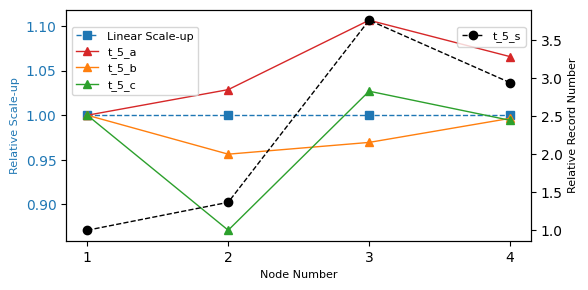

In [10]:
fig, ax1 = plt.subplots(figsize=(6, 3))

ax1.set_xlabel('Node Number', fontdict={"fontsize": 8})
ax1.set_ylabel('Relative Scale-up', color='tab:blue', fontdict={"fontsize": 8})
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax1.plot(num_node, linear_scale_up, label='Linear Scale-up', color='tab:blue', marker='s', linewidth=1, linestyle='--')
ax1.plot(num_node, t_5_a, label='t_5_a', color='tab:red', marker='^', linewidth=1)
ax1.plot(num_node, t_5_b, label='t_5_b', color='tab:orange', marker='^', linewidth=1)
ax1.plot(num_node, t_5_c, label='t_5_c', color='tab:green', marker='^', linewidth=1)

ax2 = ax1.twinx()
ax2.set_ylabel('Relative Record Number', color='black', fontdict={"fontsize": 8})
ax2.tick_params(axis='y', labelcolor='black')
ax2.plot(num_node, t_5_s, label='t_5_s', color='black', marker='o', linewidth=1, linestyle='--')

ax1.legend(fontsize=8, loc='upper left', bbox_to_anchor=(0, 0.95))
ax2.legend(fontsize=8, loc='upper right', bbox_to_anchor=(1, 0.95))
plt.xticks(num_node)
fig.savefig("figs/scaleup.pdf", bbox_inches='tight')
plt.show()